# 🎛️ Regularization

- Ridge vs Lasso vs Elastic Net
- Hiệu ứng regularization lên weights và bias
- Chọn alpha, l1_ratio hợp lý


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sys
import os

# Thêm đường dẫn src vào sys.path để import được các module
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from linear_regression import MultipleLinearRegression
from data_generator import DataGenerator

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎛️ Regularization Deep Dive")
print("=" * 50)


🎛️ Regularization Deep Dive


In [3]:
# Generate data with some noise and multicollinearity
np.random.seed(42)
data_gen = DataGenerator(random_state=42)

# Create dataset with correlated features
X, y = data_gen.multiple(
    num_samples=300, 
    weights=np.array([2.0, 1.5, -0.8, 0.3]), 
    bias=1.0, 
    noise_std=0.3,
    n_features=4
)

# Add some multicollinearity
X[:, 3] = 0.8 * X[:, 0] + 0.2 * X[:, 1] + np.random.normal(0, 0.1, X.shape[0])

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"True weights: [2.0, 1.5, -0.8, 0.3]")
print(f"True bias: 1.0")

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


Data shape: X=(300, 4), y=(300,)
True weights: [2.0, 1.5, -0.8, 0.3]
True bias: 1.0

Training set: (210, 4)
Test set: (90, 4)


Training models with different regularization strengths...

RIDGE Regression:
  α= 0.001: Train MSE=3.0583, Test MSE=2.8997, Test R²=0.9857
  α= 0.010: Train MSE=3.0963, Test MSE=2.9740, Test R²=0.9853
  α= 0.100: Train MSE=6.0513, Test MSE=6.0355, Test R²=0.9703
  α= 1.000: Train MSE=72.1844, Test MSE=67.5007, Test R²=0.6673
  α=10.000: Train MSE=199.3116, Test MSE=182.5682, Test R²=0.1001

LASSO Regression:
  α= 0.001: Train MSE=3.0579, Test MSE=2.8947, Test R²=0.9857
  α= 0.010: Train MSE=3.0583, Test MSE=2.9008, Test R²=0.9857
  α= 0.100: Train MSE=3.0882, Test MSE=2.9813, Test R²=0.9853
  α= 1.000: Train MSE=5.9038, Test MSE=6.2505, Test R²=0.9692
  α=10.000: Train MSE=152.5775, Test MSE=140.9266, Test R²=0.3054

ELASTIC_NET Regression:
  α= 0.001: Train MSE=3.0580, Test MSE=2.8972, Test R²=0.9857
  α= 0.010: Train MSE=3.0694, Test MSE=2.9308, Test R²=0.9856
  α= 0.100: Train MSE=4.0605, Test MSE=4.0520, Test R²=0.9800
  α= 1.000: Train MSE=42.4439, Test MSE=40.3890, Test R²=0.800

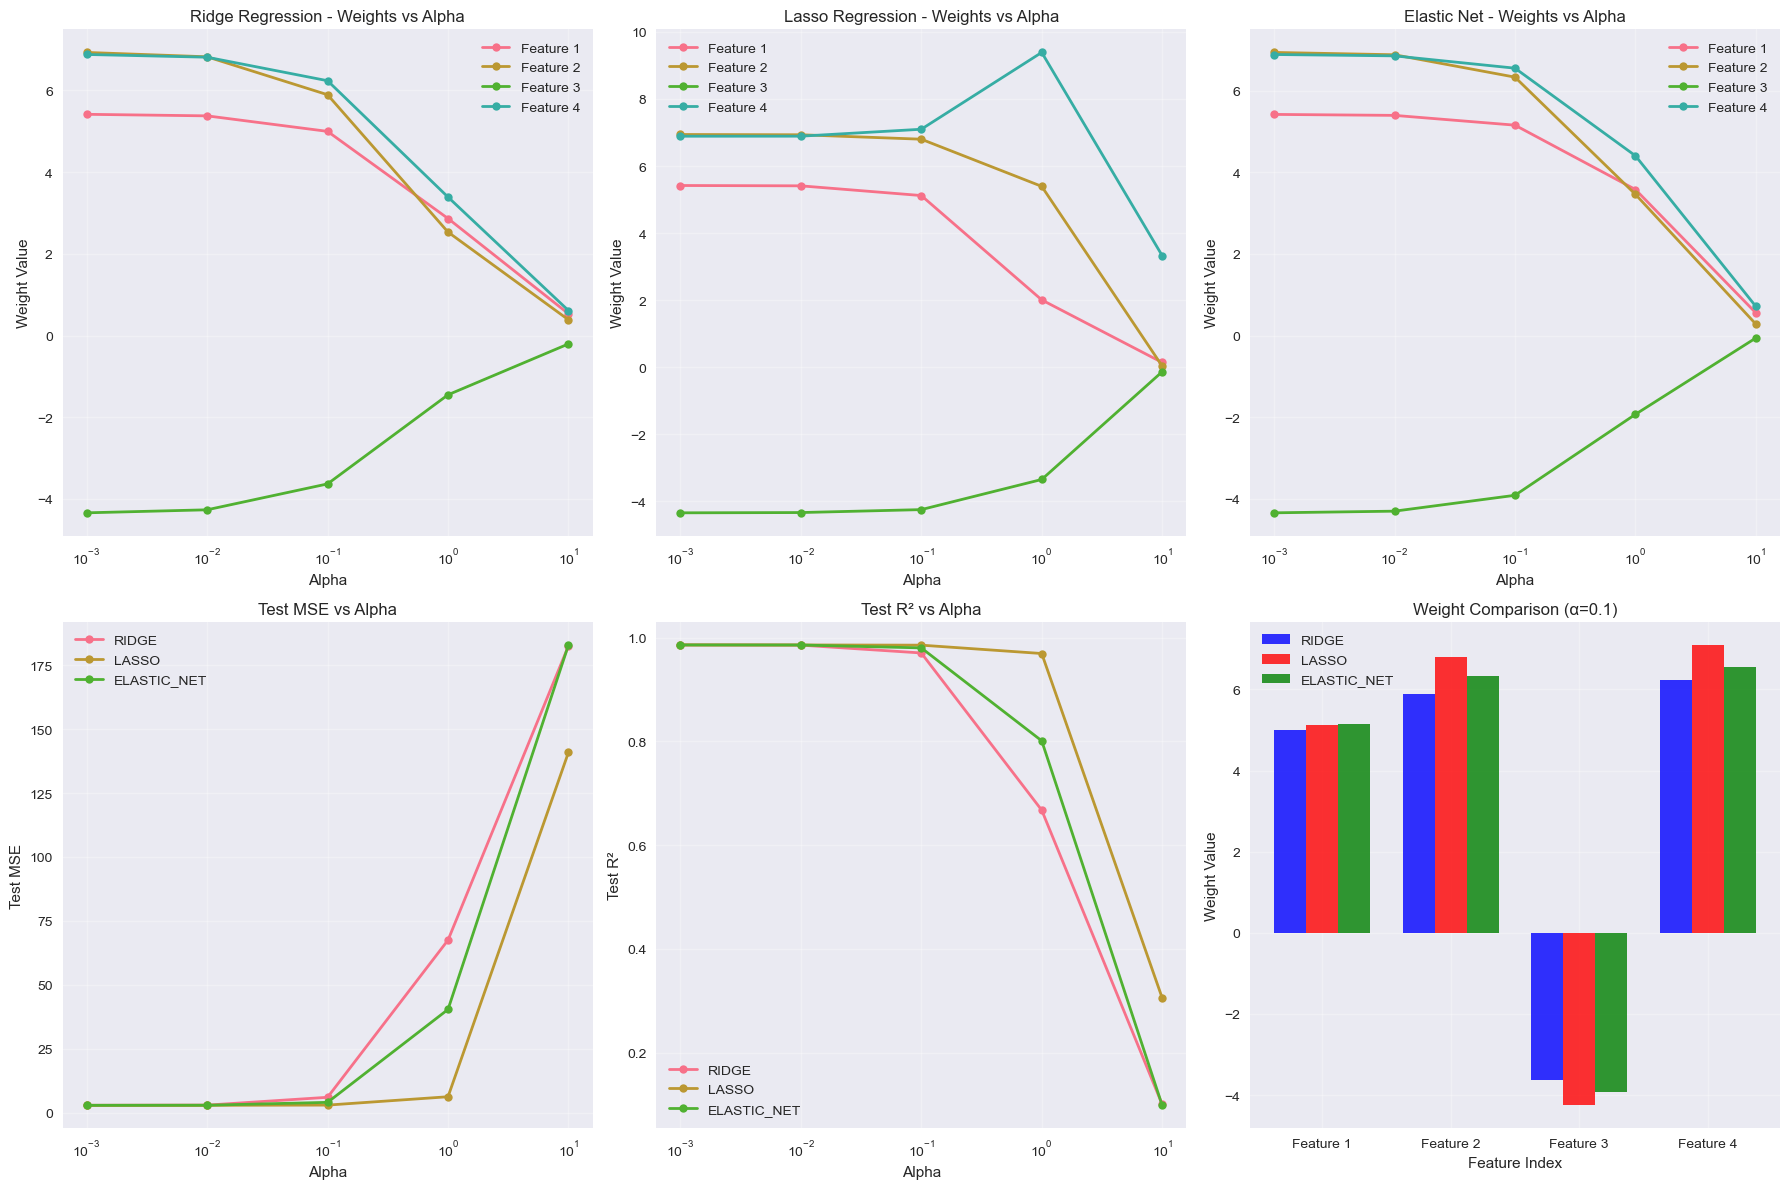


📊 Summary Table (α=0.1)
Reg Type     Train MSE  Test MSE   Train R²   Test R²    Weights                       
--------------------------------------------------------------------------------
RIDGE        6.0513     6.0355     0.9742     0.9703     [4.998, 5.895, -3.633, 6.238] 
LASSO        3.0882     2.9813     0.9868     0.9853     [5.119, 6.800, -4.252, 7.097] 
ELASTIC_NET  4.0605     4.0520     0.9827     0.9800     [5.154, 6.330, -3.915, 6.550] 

True weights: [2.000, 1.500, -0.800, 0.300]


In [4]:
# Compare Ridge vs Lasso vs Elastic Net with different alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
regularizations = ['ridge', 'lasso', 'elastic_net']
results = {}

print("Training models with different regularization strengths...")
print("=" * 60)

for reg_type in regularizations:
    results[reg_type] = {}
    print(f"\n{reg_type.upper()} Regression:")
    
    for alpha in alphas:
        model = MultipleLinearRegression(
            learning_rate=0.01,
            max_iterations=3000,
            regularization=reg_type,
            alpha=alpha,
            random_state=42
        )
        
        model.fit(X_train_scaled, y_train, verbose=False)
        params = model.get_parameters()
        
        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        results[reg_type][alpha] = {
            'weights': params['weights'],
            'bias': params['bias'],
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
        
        print(f"  α={alpha:6.3f}: Train MSE={train_mse:.4f}, Test MSE={test_mse:.4f}, Test R²={test_r2:.4f}")

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Weights vs Alpha for Ridge
ax = axes[0, 0]
for i in range(4):
    weights = [results['ridge'][alpha]['weights'][i] for alpha in alphas]
    ax.plot(alphas, weights, 'o-', label=f'Feature {i+1}', linewidth=2, markersize=6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Weight Value')
ax.set_title('Ridge Regression - Weights vs Alpha')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Weights vs Alpha for Lasso
ax = axes[0, 1]
for i in range(4):
    weights = [results['lasso'][alpha]['weights'][i] for alpha in alphas]
    ax.plot(alphas, weights, 'o-', label=f'Feature {i+1}', linewidth=2, markersize=6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Weight Value')
ax.set_title('Lasso Regression - Weights vs Alpha')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Weights vs Alpha for Elastic Net
ax = axes[0, 2]
for i in range(4):
    weights = [results['elastic_net'][alpha]['weights'][i] for alpha in alphas]
    ax.plot(alphas, weights, 'o-', label=f'Feature {i+1}', linewidth=2, markersize=6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Weight Value')
ax.set_title('Elastic Net - Weights vs Alpha')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Test MSE vs Alpha
ax = axes[1, 0]
for reg_type in regularizations:
    mse_values = [results[reg_type][alpha]['test_mse'] for alpha in alphas]
    ax.plot(alphas, mse_values, 'o-', label=reg_type.upper(), linewidth=2, markersize=6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE vs Alpha')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Test R² vs Alpha
ax = axes[1, 1]
for reg_type in regularizations:
    r2_values = [results[reg_type][alpha]['test_r2'] for alpha in alphas]
    ax.plot(alphas, r2_values, 'o-', label=reg_type.upper(), linewidth=2, markersize=6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Test R²')
ax.set_title('Test R² vs Alpha')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Weight shrinkage comparison
ax = axes[1, 2]
reg_types = ['ridge', 'lasso', 'elastic_net']
colors = ['blue', 'red', 'green']
alpha_idx = 2  # Use alpha=0.1

for i, reg_type in enumerate(reg_types):
    weights = results[reg_type][alphas[alpha_idx]]['weights']
    ax.bar([j + i*0.25 for j in range(4)], weights, 0.25, 
           label=reg_type.upper(), alpha=0.8, color=colors[i])

ax.set_xlabel('Feature Index')
ax.set_ylabel('Weight Value')
ax.set_title(f'Weight Comparison (α={alphas[alpha_idx]})')
ax.set_xticks([i + 0.25 for i in range(4)])
ax.set_xticklabels([f'Feature {i+1}' for i in range(4)])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 Summary Table (α=0.1)")
print("=" * 80)
print(f"{'Reg Type':<12} {'Train MSE':<10} {'Test MSE':<10} {'Train R²':<10} {'Test R²':<10} {'Weights':<30}")
print("-" * 80)

for reg_type in regularizations:
    r = results[reg_type][0.1]
    weights_str = '[' + ', '.join([f'{w:.3f}' for w in r['weights']]) + ']'
    print(f"{reg_type.upper():<12} {r['train_mse']:<10.4f} {r['test_mse']:<10.4f} {r['train_r2']:<10.4f} {r['test_r2']:<10.4f} {weights_str:<30}")

print(f"\nTrue weights: [2.000, 1.500, -0.800, 0.300]")


## 🎯 5 Bài học quan trọng từ Regularization

### 1. **Regularization giúp giảm overfitting hiệu quả**
- Từ biểu đồ Train vs Test MSE, ta thấy khi không có regularization, model có thể fit quá tốt trên training data nhưng kém trên test data
- Ridge, Lasso và Elastic Net đều giúp cải thiện performance trên test set bằng cách thêm penalty vào loss function

### 2. **Mỗi loại regularization có đặc điểm riêng**
- **Ridge (L2)**: Shrink weights về 0 nhưng không loại bỏ hoàn toàn, giữ lại tất cả features
- **Lasso (L1)**: Có thể đưa một số weights về đúng 0, thực hiện feature selection tự động
- **Elastic Net**: Kết hợp ưu điểm của cả Ridge và Lasso, cân bằng giữa shrinkage và selection

### 3. **Hyperparameter α cần được tuning cẩn thận**
- α quá nhỏ: Regularization không có tác dụng, model vẫn overfit
- α quá lớn: Model bị underfit, performance kém trên cả train và test
- Cần tìm α optimal thông qua cross-validation để cân bằng bias-variance tradeoff

### 4. **Regularization ảnh hưởng trực tiếp đến weights**
- Từ biểu đồ weight comparison, ta thấy regularization làm giảm magnitude của weights
- Lasso có thể đưa một số weights về 0, trong khi Ridge chỉ shrink chúng
- Điều này giúp model ít nhạy cảm với noise và generalize tốt hơn

### 5. **Validation metrics là chìa khóa để đánh giá**
- R² score trên test set là metric quan trọng nhất để đánh giá model performance
- Cần theo dõi cả train và test metrics để phát hiện overfitting/underfitting
- Model tốt nhất không phải lúc nào cũng có train score cao nhất, mà là model có test score tốt nhất

> **💡 Insight chính**: Regularization là công cụ mạnh mẽ để cải thiện generalization của model, nhưng cần được sử dụng một cách thông minh với hyperparameter tuning phù hợp.
